# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image
import urllib
from urllib.request import urlopen

# Load shots data from Understat

In [2]:
shots = pd.read_csv("Data\\KolnvBayern_shots.csv")
shots.head(10)

,id,competition,season,datetime,minute,result,x,y,x_g,player,...,situation,shot_type,match_id,team_home,team_away,goals_home,goals_away,date,player_assisted,last_action
0,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,1,MissedShots,0.857,0.454,0.061095,Florian Kainz,...,OpenPlay,RightFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,Dejan Ljubicic,Cross
1,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,22,MissedShots,0.879,0.452,0.138264,Eric Martel,...,OpenPlay,RightFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,Davie Selke,Pass
2,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,26,BlockedShot,0.780,0.692,0.017752,Florian Kainz,...,OpenPlay,RightFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,NaN,None
3,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,30,MissedShots,0.881,0.413,0.031950,Davie Selke,...,OpenPlay,Head,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,Dejan Ljubicic,Cross
4,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,55,MissedShots,0.728,0.601,0.013935,Jonas Hector,...,OpenPlay,LeftFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,NaN,None
5,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,59,SavedShot,0.897,0.587,0.032895,Davie Selke,...,FromCorner,Head,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,Florian Kainz,Cross
6,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,73,MissedShots,0.948,0.564,0.103020,Ellyes Skhiri,...,FromCorner,LeftFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,Jan Thielmann,HeadPass
7,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,80,Goal,0.885,0.500,0.757777,Dejan Ljubicic,...,Penalty,RightFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,NaN,Standard
8,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,7,Goal,0.840,0.704,0.031590,Kingsley Coman,...,OpenPlay,RightFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,Leroy Sané,Pass
9,1685145600---fc_cologne---bayern_munich,DEU Bundesliga 1,2022-2023,2023-05-27 13:30:00,16,BlockedShot,0.865,0.645,0.069314,Leroy Sané,...,OpenPlay,LeftFoot,19642,FC Cologne,Bayern Munich,1,2,2023-05-27,Noussair Mazraoui,Pass


In [3]:
team_home = 'FC Cologne'
team_away = 'Bayern Munich'

# Cleaning data

In [4]:
# Create a new df 
df = shots[['minute', 'result', 'x_g', 'player', 'h_a', 'team_home', 'team_away']]

# Change data type
df = df.astype({'minute':float, 'x_g':float})

# Create 2 dfs for 2 teams and rename column
h_df = df[df['h_a']=='h'][['minute', 'result', 'x_g', 'player', 'team_home']]
a_df = df[df['h_a']=='a'][['minute', 'result', 'x_g', 'player', 'team_away']]

# Rename the team column
h_df.rename(columns={'team_home':'team'}, inplace=True)
a_df.rename(columns={'team_away':'team'}, inplace=True)

# Add 0 xg to the beginning and the end of the game, then sort the df
new_rows = pd.DataFrame({'minute': [0, 90], 'x_g': [0, 0]})
h_df = h_df.append(new_rows, ignore_index=True)
a_df = a_df.append(new_rows, ignore_index=True)

h_df.sort_values('minute', ascending=True, inplace=True)
a_df.sort_values('minute', ascending=True, inplace=True)

# Create a new Cumulative xG column
h_df['xGcum'] = np.cumsum(h_df['x_g'])
a_df['xGcum'] = np.cumsum(a_df['x_g'])

# Create the dictionaries
h_x = h_df[h_df['result']=='Goal']['minute'].tolist()
a_x = a_df[a_df['result']=='Goal']['minute'].tolist()

h_y = h_df[h_df['result']=='Goal']['xGcum'].tolist()
a_y = a_df[a_df['result']=='Goal']['xGcum'].tolist()

# xG point inside the scatterplots
h_xG = np.round(h_df[h_df['result']=='Goal']['x_g'], 2).tolist()
a_xG = np.round(a_df[a_df['result']=='Goal']['x_g'], 2).tolist()

# Annotation text for scorer
text_home = h_df[h_df['result']=='Goal']['player'].tolist()
text_away = a_df[a_df['result']=='Goal']['player'].tolist()

# Annotation for Total xG
xGcum_home = str(np.round(h_df['xGcum'].iloc[-1], 2))
xGcum_away = str(np.round(a_df['xGcum'].iloc[-1], 2))

C:\Users\lupin\AppData\Local\Temp\ipykernel_4380\3043883486.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  h_df = h_df.append(new_rows, ignore_index=True)
C:\Users\lupin\AppData\Local\Temp\ipykernel_4380\3043883486.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a_df = a_df.append(new_rows, ignore_index=True)


# Plot the xG flowchart

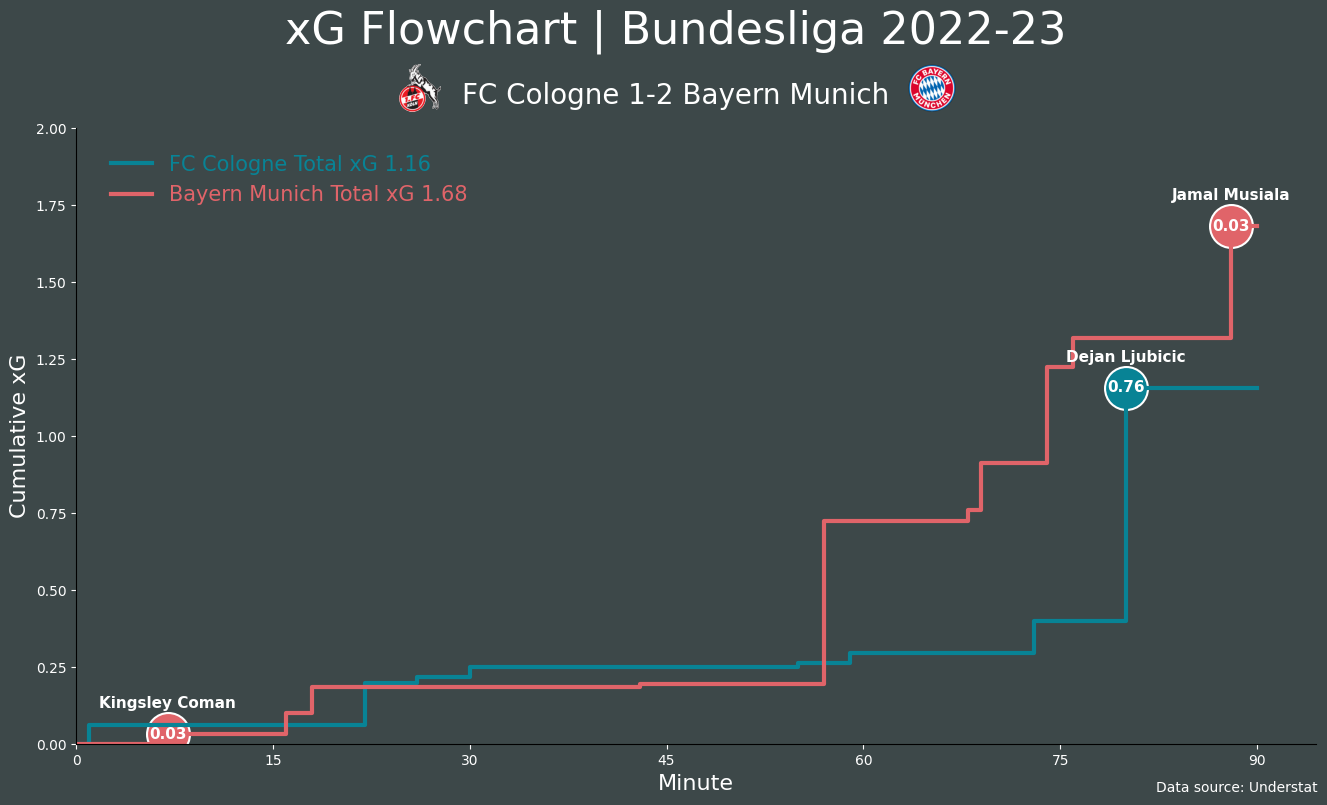

In [5]:
# Set the color for home away team
h_color = '#088395'
a_color = '#E06469'

# Set the basic plot for the flow chart
fig, ax = plt.subplots(figsize=(16, 8))
fig.set_facecolor('#3d4849')
ax.patch.set_facecolor('#3d4849')

# Set the x, y labels
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Minute', color='white', fontsize=16)
plt.ylabel('Cumulative xG', color='white', fontsize=16)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Step plot for the game
ax.step(x=h_df['minute'], y=h_df['xGcum'], where='post', color=h_color, linewidth=3)
ax.step(x=a_df['minute'], y=a_df['xGcum'], where='post', color=a_color, linewidth=3)

# Add goals
ax.scatter(x=h_x, y=h_y, color=h_color, edgecolor='white', s=955, linewidths=1.5)
ax.scatter(x=a_x, y=a_y, color=a_color, edgecolor='white', s=955, linewidths=1.5)

# Add xG at goals
for i in range(len(h_xG)):
    plt.annotate(h_xG[i], (h_x[i], h_y[i]), color='white', size=11, ha='center', va='center', fontweight='bold')

for i in range(len(a_xG)):
    plt.annotate(a_xG[i], (a_x[i], a_y[i]), color='white', size=11, ha='center', va='center', fontweight='bold')
    
# Add scorer names
for i in range(len(h_xG)):
    plt.annotate(text_home[i], (h_x[i], h_y[i]+0.1), color='white', size=11, ha='center', va='center', fontweight='bold')

for i in range(len(a_xG)):
    plt.annotate(text_away[i], (a_x[i], a_y[i]+0.1), color='white', size=11, ha='center', va='center',fontweight='bold')

# Adjust x, y axis
plt.ylim(0, 2)
plt.xlim(xmin=0)

# Add title 
fig.text(0.5, 1, "xG Flowchart | Bundesliga 2022-23", 
         horizontalalignment='center',
         verticalalignment='center',
         color='white',
         fontsize=32
        )
fig.text(0.5, 0.92, f"{team_home} 1-2 {team_away}", 
         horizontalalignment='center',
         verticalalignment='center',
         color='white',
         fontsize=20
        )

# Add logos for home and away team
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
h_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{8722:.0f}.png"))
ax = fig.add_axes([0.31, 0.9, 0.06, 0.06])
ax.imshow(h_icon)
ax.axis("off")

a_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{9823:.0f}.png"))
ax = fig.add_axes([0.63, 0.9, 0.06, 0.06])
ax.imshow(a_icon)
ax.axis("off")

# Add legends
h_line = Line2D([], [], color=h_color, linestyle='-', linewidth=3)
a_line = Line2D([], [], color=a_color, linestyle='-', linewidth=3)

h_total_xG = f"{team_home} Total xG {xGcum_home}"
a_total_xG = f"{team_away} Total xG {xGcum_away}"

plt.legend(handles=[h_line, a_line], labels=[h_total_xG, a_total_xG], fontsize=15,
           loc='upper left', bbox_to_anchor=(-17, -0.5), frameon=False, labelcolor='linecolor')

# Add data source
fig.text(0.8, 0.05, "Data source: Understat", color='white')


plt.show()